<a href="https://colab.research.google.com/github/GuchaIll/SpaceJam/blob/main/SpaceJamModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install anvil-uplink

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.4/51.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ws4py: filename=ws4py-0.5.1-py3-none-any.whl size=45228 sha256=f50a2b8f9a3eea9ed3042b1596eaf23f0e4783332041d46a20b17ec8a9cb18d5
  Stored in directory: /root/.cache/pip/wheels/2e/7c/ad/d9c746276bf024d44296340869fcb169f1e5d80fb147351a57
Successfully built ws4py


In [ ]:
import anvil.server
anvil.server.connect("server_TP5XCRFVQ66ZH2GJ5VWHVSJR-XDMBZVSOFWIXVH5U")

Connecting to wss://anvil.works/uplink
Anvil websocket open
Connected to "Default Environment" as SERVER


In [ ]:
import numpy as np
import sys
import tensorflow as tf
from tensorflow.keras import Input, utils,metrics,models,optimizers, callbacks

from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, UpSampling2D, Conv2DTranspose,ReLU
from keras.models import Model
from keras.optimizers import Adam

import matplotlib.pyplot as plt

import pandas as pd


In [ ]:
import os
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Create a folder in the root directory
#!mkdir -p "/content/drive/My Drive/AnimeGAN"

Mounted at /content/drive


In [ ]:
!pip install -q -U tensorboard-plugin-profile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 4.6 MB/s eta 0:00:00


In [ ]:
IMAGE_SIZE = 64
CHANNELS = 3
BATCH_SIZE = 512
NUM_FEATURES = 64
Z_DIM = 128
LEARNING_RATE = 0.0001
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.999
EPOCHS = 200
CRITIC_STEPS = 3
GP_WEIGHT = 10.0
LOAD_MODEL = True
ADAM_BETA_1 = 0.5
ADAM_BETA_2 = 0.9

In [ ]:

def sample_batch(dataset):
    batch = dataset.take(1).get_single_element()
    if isinstance(batch, tuple):
        batch = batch[0]
    return batch.numpy()


def display(
    images, n=10, size=(20, 3), cmap="gray_r", as_type="float32", save_to=None
):
    """
    Displays n random images from each one of the supplied arrays.
    """
    if images.max() > 1.0:
        images = images / 255.0
    elif images.min() < 0.0:
        images = (images + 1.0) / 2.0

    plt.figure(figsize=size)
    for i in range(n):
        _ = plt.subplot(1, n, i + 1)
        plt.imshow(images[i].astype(as_type), cmap=cmap)
        plt.axis("off")

    if save_to:

        plt.savefig(save_to)
        print(f"\nSaved to {save_to}")

    plt.show()

In [ ]:
train_data = utils.image_dataset_from_directory(
    "/content/drive/MyDrive/SpaceJam/Images/Train", #change path
    labels=None,
    color_mode="rgb",
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
    interpolation="bilinear",
)

Found 1650 files belonging to 1 classes.


In [ ]:
def preprocess(img):
  iimg = tf.image.resize(img, (IMAGE_SIZE,IMAGE_SIZE), method=tf.image.ResizeMethod.BILINEAR)
  img = (tf.cast(img, "float32") - 127.5) / 127.5
  return img

train = train_data.map(lambda x: preprocess(x))
print(train)

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 3), dtype=tf.float32, name=None)>


In [ ]:
train_sample = sample_batch(train)

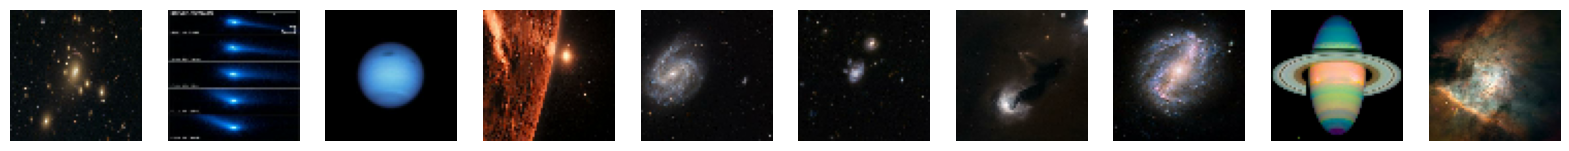

In [ ]:
display(train_sample, cmap = None)

In [ ]:
def residual_block(input):
    # Shortcut connection

    # First convolution layer
    x = Conv2D(512, kernel_size=(3,3), strides=1, padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Second convolution layer
    x = Conv2D(512, kernel_size=(3,3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # Add shortcut to the output (residual connection)
    x = Add()([x, input])
    x = ReLU()(x)

    return x

In [ ]:
critic_input = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
x = Conv2D(64, kernel_size=4, strides=2, padding="same")(critic_input)
x = LeakyReLU(0.2)(x)
x = Conv2D(128, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU()(x)
x = Dropout(0.3)(x)

x = Conv2D(128, kernel_size=4, strides=1, padding="same")(x)
x = LeakyReLU()(x)

x = Conv2D(256, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)

x = Conv2D(256, kernel_size=4, strides=1, padding="same")(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(512, kernel_size=4, strides=2, padding="same")(x)
x = LeakyReLU(0.2)(x)
x = Dropout(0.3)(x)

x = Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(1, kernel_size=4, strides=1, padding="valid")(x)
critic_output = Flatten()(x)

critic = Model(critic_input, critic_output)
critic.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131200    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 16, 16, 128)       0         
                                                                 
 dropout (Dropout)           (None, 16, 16, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 16, 16, 128)       262272

In [ ]:
generator_input = Input(shape=(Z_DIM,))
x = Reshape((1, 1, Z_DIM))(generator_input)
x = Conv2DTranspose(
    512, kernel_size=4, strides=1, padding="valid", use_bias=False)(x)

x = Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
x = LeakyReLU(0.2)(x)

x = Conv2D(512, kernel_size=4, strides=1, padding="same")(x)
x = LeakyReLU(0.2)(x)


x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(
    256, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(
    128, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)
x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
x = Conv2DTranspose(
    64, kernel_size=4, strides=2, padding="same", use_bias=False
)(x)

x = BatchNormalization(momentum=0.9)(x)
x = LeakyReLU(0.2)(x)
generator_output = Conv2DTranspose(
    CHANNELS, kernel_size=4, strides=2, padding="same", activation="tanh"
)(x)


generator = Model(generator_input, generator_output)
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 128)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         1048576   
 anspose)                                                        
                                                                 
 conv2d_8 (Conv2D)           (None, 4, 4, 512)         4194816   
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 4, 4, 512)         4194816   
                                                           

In [ ]:
class WGANGP(models.Model):
    def __init__(self, critic, generator, latent_dim, critic_steps, gp_weight):
        super(WGANGP, self).__init__()
        self.critic = critic
        self.generator = generator
        self.latent_dim = latent_dim
        self.critic_steps = critic_steps
        self.gp_weight = gp_weight

    def compile(self, c_optimizer, g_optimizer):
        super(WGANGP, self).compile()
        self.c_optimizer = c_optimizer
        self.g_optimizer = g_optimizer
        self.c_wass_loss_metric = metrics.Mean(name="c_wass_loss")
        self.c_gp_metric = metrics.Mean(name="c_gp")
        self.c_loss_metric = metrics.Mean(name="c_loss")
        self.g_loss_metric = metrics.Mean(name="g_loss")

    @property
    def metrics(self):
        return [
            self.c_loss_metric,
            self.c_wass_loss_metric,
            self.c_gp_metric,
            self.g_loss_metric,
        ]

    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.critic(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2, 3]))
        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]

        for i in range(self.critic_steps):
            random_latent_vectors = tf.random.normal(
                shape=(batch_size, self.latent_dim)
            )

            with tf.GradientTape() as tape:
                fake_images = self.generator(
                    random_latent_vectors, training=True
                )
                fake_predictions = self.critic(fake_images, training=True)
                real_predictions = self.critic(real_images, training=True)

                c_wass_loss = tf.reduce_mean(fake_predictions) - tf.reduce_mean(
                    real_predictions
                )
                c_gp = self.gradient_penalty(
                    batch_size, real_images, fake_images
                )
                c_loss = c_wass_loss + c_gp * self.gp_weight

            c_gradient = tape.gradient(c_loss, self.critic.trainable_variables)
            self.c_optimizer.apply_gradients(
                zip(c_gradient, self.critic.trainable_variables)
            )

        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_latent_vectors, training=True)
            fake_predictions = self.critic(fake_images, training=True)
            g_loss = -tf.reduce_mean(fake_predictions)

        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(
            zip(gen_gradient, self.generator.trainable_variables)
        )

        self.c_loss_metric.update_state(c_loss)
        self.c_wass_loss_metric.update_state(c_wass_loss)
        self.c_gp_metric.update_state(c_gp)
        self.g_loss_metric.update_state(g_loss)

        return {m.name: m.result() for m in self.metrics}


In [ ]:
# Create a GAN
wgangp = WGANGP(
    critic=critic,
    generator=generator,
    latent_dim=Z_DIM,
    critic_steps=CRITIC_STEPS,
    gp_weight=GP_WEIGHT,
)

In [ ]:
if LOAD_MODEL:
    wgangp.load_weights("/content/drive/MyDrive/SpacezJam3/checkpoints/checkpoint.ckpt")

In [ ]:
# Compile the GAN
wgangp.compile(
    c_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
    g_optimizer=optimizers.Adam(
        learning_rate=LEARNING_RATE, beta_1=ADAM_BETA_1, beta_2=ADAM_BETA_2
    ),
)

In [ ]:
# Create a model save checkpoint
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="/content/drive/MyDrive/SpacezJam3/checkpoints/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="/content/drive/MyDrive/SpacezJam3/logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            cmap=None,
        )

In [ ]:
!mkdir /content/checkpoint

In [ ]:
!pip install tensorboardcolab


  Preparing metadata (setup.py) ... done
  Created wheel for tensorboardcolab: filename=tensorboardcolab-0.0.22-py3-none-any.whl size=3834 sha256=d718f2dd0acf8d9e80929650d5b52bb232c38630182d56cb040afbd501cccf22
  Stored in directory: /root/.cache/pip/wheels/8d/ee/46/7fe2bbbf1edbcfeabfaf13962dcaadec1f631d11147fd9d34d
Successfully built tensorboardcolab


In [ ]:
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
tbc = TensorBoardColab()

Wait for 8 seconds...
TensorBoard link:
https://15a3-35-194-162-11.ngrok.io


In [ ]:
%load_ext tensorboard
!rm -rf /content/drive/MyDrive/SpacezJam3/logs

In [ ]:


train = train.repeat()

print(train)
wgangp.fit(
    train,
    epochs=EPOCHS,
    steps_per_epoch=3,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=Z_DIM),
    ],
)

In [ ]:
# Save the final models
generator.save("./models/generator")
critic.save("./models/critic")

In [ ]:
%cp -av "./models" "/content/drive/MyDrive/SpacezJam3/models"
%cp -av "./checkpoint" "/content/drive/MyDrive/SpacezJam3/checkpoints"


'./models/generator/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/SpacezJam3/models/models/generator/variables/variables.data-00000-of-00001'
'./models/generator/variables/variables.index' -> '/content/drive/MyDrive/SpacezJam3/models/models/generator/variables/variables.index'
'./models/generator/saved_model.pb' -> '/content/drive/MyDrive/SpacezJam3/models/models/generator/saved_model.pb'
'./models/generator/fingerprint.pb' -> '/content/drive/MyDrive/SpacezJam3/models/models/generator/fingerprint.pb'
'./models/generator/keras_metadata.pb' -> '/content/drive/MyDrive/SpacezJam3/models/models/generator/keras_metadata.pb'
'./models/critic/variables/variables.data-00000-of-00001' -> '/content/drive/MyDrive/SpacezJam3/models/models/critic/variables/variables.data-00000-of-00001'
'./models/critic/variables/variables.index' -> '/content/drive/MyDrive/SpacezJam3/models/models/critic/variables/variables.index'
'./models/critic/saved_model.pb' -> '/content/drive/MyDrive/Spac

2/2 [==============================] - 1s 232ms/step

Saved to /content/drive/MyDrive/Images/Image50/Img3.png


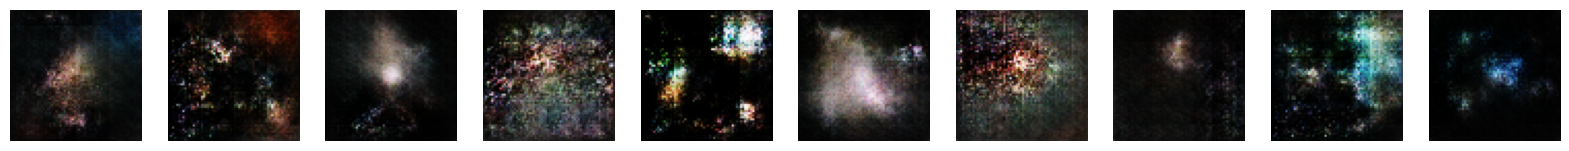

In [ ]:
z_sample = np.random.normal(size=(50, Z_DIM))
imgs = wgangp.generator.predict(z_sample)
display(imgs, cmap=None, save_to="/content/drive/MyDrive/Images/Image50/Img3.png")

In [ ]:
@anvil.server.callable
def generate_image():
  z_sample = np.random.normal(size=(50, Z_DIM))
  imgs = wgangp.generator.predict(z_sample)
  display(imgs, cmap=None, save_to="Img3.png")
  return "Img3.png"


1/1 [==============================] - 0s 213ms/step


IndexError: ignored

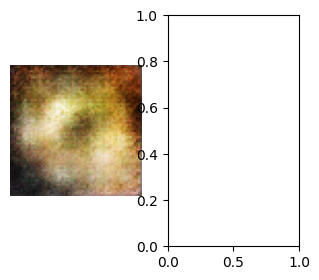

In [ ]:
from PIL import Image

n=10
size=(20, 3)
cmap="gray_r"
as_type="float32"
for j in range(3):
  z_sample = np.random.normal(size=(1, Z_DIM))
  images = wgangp.generator.predict(z_sample)
  if images.max() > 1.0:
      images = images / 255.0
  elif images.min() < 0.0:
      images = (images + 1.0) / 2.0

  plt.figure(figsize=size)
  for i in range(n):
      _ = plt.subplot(1, n, i + 1)
      plt.imshow(images[i].astype(as_type), cmap=cmap)
      plt.axis("off")


  plt.show()
  #imgs = np.uint8(imgs)
  #image = Image.fromarray(imgs[0])
  plt.savefig(f"/content/drive/MyDrive/Images/Image50/I{j}.png")